In [0]:
in_google_drive = True

# Embedding Layer

In [0]:
import numpy as np

## Simple Example

In [0]:
W = np.arange(21).reshape(7,3)

In [4]:
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [5]:
class_id = 2
W[class_id]

array([6, 7, 8])

In [6]:
batch_class_id = np.array([0,2,1,3])
W[batch_class_id]

array([[ 0,  1,  2],
       [ 6,  7,  8],
       [ 3,  4,  5],
       [ 9, 10, 11]])

In [0]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        # not a good example
        # we only need to keep index and its relative dout value
        dW, = self.grads
        dW[...] = 0
        
        # the following idea is correct, but in practical
        # it meets problem when meeting the same index
        # dW[self.idx] = dout 
        
        #for idx, word_id in enumerate(self.idx):
        #    dW[word_id] += dout[idx]
        
        # more higher efficiency
        np.add.at(dW, self.idx, dout)
        return None

# Negative Sampling

Change the issue from multiple categories into binary categories. The question would be changed to `Is the result word 'say', when the context are 'you' and 'goodbye'?` -> Binary Results (Yes/No)

In [0]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### Ways to Nagitive Sampling

In [9]:
# sampling from 0 to 9
print(np.random.choice(10))

# sampling from a list
words = ['you', 'say', 'goodbye', 'and', 'i', 'hello', '.']
print(np.random.choice(words))

# randomly choice 5 words (allowed duplication)
print(np.random.choice(words, size=5))

# randomly choice 5 words (no duplication)
print(np.random.choice(words, size=5, replace=False))

# sampling based on the probabilistic distribution
prob = [0.5, 0.1, 0.05, 0.1, 0.1, 0.05, 0.1]
print(np.random.choice(words, p=prob))

2
and
['hello' 'hello' 'goodbye' 'goodbye' '.']
['i' 'you' '.' 'say' 'goodbye']
and


Increase the probabilities of rare words.

In [10]:
new_prob = np.power(prob, 0.75)
new_prob = new_prob / np.sum(new_prob)
print(new_prob)

[0.39185952 0.11719333 0.06968357 0.11719333 0.11719333 0.06968357
 0.11719333]


In [11]:
np.array([1,2,3]).shape

(3,)

In [0]:
import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        self.vocab_size = len(counts)
        
        self.word_p = np.zeros(self.vocab_size)
        for i in range(self.vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p = self.word_p / np.sum(self.word_p)
    
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        nagative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
        for i in range(batch_size):
            _p = self.word_p.copy()
            target_idx = target[i]
            _p[target_idx] = 0
            _p /= _p.sum()
            nagative_sample[i,:] = np.random.choice(self.vocab_size, size=self.sample_size, p=_p)
            
        return nagative_sample

In [13]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_samples = sampler.get_negative_sample(target)
print(negative_samples)

[[0 0]
 [2 4]
 [2 3]]


## Negative Sampling Loss

In [0]:
import os, sys
from google.colab import drive

In [15]:
if in_google_drive:
  drive.mount('/content/gdrive')
  lib_path = os.path.join("/content/gdrive/My Drive/deep_learning_from_scratch")
else:
  lib_path = os.path.join(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
print(os.path.exists(lib_path))

True


In [0]:
sys.path.append(lib_path)

In [0]:
from common.layers import SigmoidWithLoss

In [0]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.corpus = corpus
        self.sampler = UnigramSampler(corpus=corpus, power=power, sample_size=sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(self.sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(self.sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # positive samples
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # negative samples
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:,i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

# CBOW with Embedding and Negative Sampling

In [0]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # initialize weights
        W_in = 1e-2 * np.random.randn(V, H).astype('f')
        W_out = 1e-2 * np.random.randn(V, H).astype('f')
        
        # initialize layers
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus=corpus, power=0.75, sample_size=5)
        
        # grads and params
        self.params, self.grads = [], []
        for layer in self.in_layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # word vector
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

## Training

In [21]:
if in_google_drive:
  ds_path = os.path.join("/content/gdrive/My Drive/deep_learning_from_scratch/dataset")
else:
  ds_path = os.path.join(".", "dataset")
 
print(os.path.exists(ds_path))

True


In [0]:
sys.path.append(ds_path)

In [0]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu
import ptb

In [0]:
# hyperparameters
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 50

In [0]:
# load dataset
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

In [0]:
contexts, target = create_contexts_target(corpus=corpus, window_size=window_size)

In [0]:
# model generation
model = CBOW(vocab_size=vocab_size, hidden_size=hidden_size, window_size=window_size, corpus=corpus)
optimizer = Adam()
trainer = Trainer(model=model, optimizer=optimizer)

In [28]:
# start training
trainer.fit(contexts, target, max_epoch=max_epoch, batch_size=batch_size)

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 2[s] | loss 4.16
| epoch 1 |  iter 61 / 9295 | time 3[s] | loss 4.16
| epoch 1 |  iter 81 / 9295 | time 4[s] | loss 4.16
| epoch 1 |  iter 101 / 9295 | time 5[s] | loss 4.16
| epoch 1 |  iter 121 / 9295 | time 7[s] | loss 4.16
| epoch 1 |  iter 141 / 9295 | time 8[s] | loss 4.16
| epoch 1 |  iter 161 / 9295 | time 9[s] | loss 4.16
| epoch 1 |  iter 181 / 9295 | time 10[s] | loss 4.16
| epoch 1 |  iter 201 / 9295 | time 11[s] | loss 4.16
| epoch 1 |  iter 221 / 9295 | time 12[s] | loss 4.16
| epoch 1 |  iter 241 / 9295 | time 13[s] | loss 4.16
| epoch 1 |  iter 261 / 9295 | time 14[s] | loss 4.16
| epoch 1 |  iter 281 / 9295 | time 16[s] | loss 4.16
| epoch 1 |  iter 301 / 9295 | time 17[s] | loss 4.16
| epoch 1 |  iter 321 / 9295 | time 18[s] | loss 4.16
| epoch 1 |  iter 341 / 9295 | time 19[s] | loss 4.16
| epoch 1 |  iter 361 / 9295 | time 20[s] |

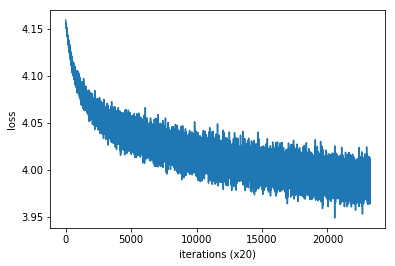

In [29]:
trainer.plot()

In [0]:
# save model
word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params["word_to_id"] = word_to_id
params["id_to_word"] = id_to_word

if in_google_drive:
  pkl_file = "/content/gdrive/My Drive/deep_learning_from_scratch/tmp/cbow_params.pkl"  
else:
  pkl_file = os.path.join(".","tmp","cbow_params.pkl")

In [0]:
import pickle
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)

## Evaluate the CBOW word2vec

In [0]:
from common.util import most_similar

Load trained word vector.

In [0]:
if in_google_drive:
  pkl_file = "/content/gdrive/My Drive/deep_learning_from_scratch/tmp/cbow_params.pkl"  
else:
  pkl_file = os.path.join(".","tmp","cbow_params.pkl")

In [0]:
assert os.path.exists(pkl_file), "Pkl file dosen't exist."

In [0]:
with open(pkl_file, 'rb') as fin:
  params = pickle.load(fin)
  word_vecs = params["word_vecs"]
  word_to_id = params["word_to_id"]
  id_to_word = params["id_to_word"]

Find most similar words.

In [36]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.7158203125
 we: 0.71240234375
 your: 0.65625
 they: 0.63525390625
 never: 0.59521484375

[query] year
 month: 0.8017578125
 week: 0.72998046875
 spring: 0.50830078125
 modest: 0.4970703125
 gain: 0.48291015625

[query] car
 boost: 0.5458984375
 fit: 0.521484375
 chance: 0.52099609375
 portfolio: 0.5205078125
 weapon: 0.51220703125

[query] toyota
 honda: 0.5546875
 ford: 0.5302734375
 sometimes: 0.52880859375
 fans: 0.51513671875
 fees: 0.5146484375


Analogy questions.

In [0]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [0]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5):
  for word in [a, b, c]:
    if word not in word_to_id:
      print("{} is not found.".format(word))
  a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], \
    word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
  query_vec = b_vec - a_vec + c_vec
  query_vec = normalize(query_vec)
  similarity = np.dot(word_matrix, query_vec)
  
  count = 0
  for i in (-1 * similarity).argsort():
    if np.isnan(similarity[i]) or id_to_word[i] in [a,b,c]:
      continue
    print("{0}:{1}".format(id_to_word[i], similarity[i]))
    
    count += 1
    if count >= top:
      return

In [39]:
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs)
print()
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)
print()
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)
print()
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)

spokesman:45.84375
company:39.75
earlier:36.46875
share:34.96875
result:33.40625

of:25.390625
are:25.234375
were:23.625
to:21.078125
're:18.921875

the:45.78125
a.m:44.3125
volume:37.3125
revenue:35.53125
sales:33.46875

<eos>:67.25
and:46.125
are:36.0625
a:34.9375
more:34.125
